In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!python3 -m pip install watermark
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,seaborn,tensorflow,matplotlib -a Filippo_Valle -g -r -b -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Filippo_Valle 
last updated: Fri Jan 22 2021 

CPython 3.6.9
IPython 5.5.0

pandas 1.1.5
numpy 1.19.5
seaborn 0.11.1
tensorflow 2.4.0
matplotlib 3.2.2

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : 
Git repo   : 
Git branch : 
watermark 2.0.2


In [4]:
import pandas as pd
import numpy as np
import os,sys, gc
import matplotlib.pyplot as plt
!pip install --extra-index https://test.pypi.org/simple pandarallel topicpy
from topicpy.hsbmpy import get_max_available_L

os.environ["TF_CUDNN_USE_AUTOTUNE"]="0" #avoids Nvidia GPU warming up

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 532kB 32.7MB/s 
     |████████████████████████████████| 235kB 46.9MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 153kB 46.5MB/s 
     |████████████████████████████████| 5.5MB 50.3MB/s 
     |████████████████████████████████| 245kB 58.7MB/s 
     |████████████████████████████████| 163kB 62.1MB/s 
  Created wheel for pandarallel: filename=pandarallel-1.5.1-cp36-none-any.whl size=17127 sha256=6d44e6fc3c435213103592b12e1e32cbb0f8f9f8e82f78b117a8091ebdff157d
  Stored in directory: /root/.cache/pip/wheels/6f/c8/e5/d43fa63105ce1dd22f4df51bc2edfefd54d92ce64f25326314
  Created wheel for bioservices: filename=bioservices-1.7.11-cp36-none-any.whl size=236089 sha256=b63f1f2e33a452275d386a214bb3a1060c81e4d8009b5657990ac070f3fc71e1
  Stored in directory: /root/.cache/pip/wheels/60/6

In [6]:
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/topics/datasets/gtex10'
L = get_max_available_L(directory, algorithm)-2
os.chdir(directory)

In [130]:
label = 'SMTSD'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head(2)

,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,SMUBRID,SMTSISCH,SMTSPAX,SMNABTCH,SMNABTCHT,SMNABTCHD,SMGEBTCH,SMGEBTCHD,SMGEBTCHT,SMAFRZE,SMGTC,SME2MPRT,SMCHMPRS,SMNTRART,SMNUMGPS,SMMAPRT,SMEXNCRT,SM550NRM,SMGNSDTC,SMUNMPRT,SM350NRM,SMRDLGTH,SMMNCPB,SME1MMRT,SMSFLGTH,SMESTLBS,SMMPPD,SMNTERRT,SMRRNANM,SMRDTTL,SMVQCFL,SMMNCV,SMTRSCPT,SMMPPDPR,SMCGLGTH,SMGAPPCT,SMUNPDRD,SMNTRNRT,SMMPUNRT,SMEXPEFF,SMMPPDUN,SME2MMRT,SME2ANTI,SMALTALG,SME2SNSE,SMMFLGTH,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,LCSET-4574,01/15/2014,Standard Exome Sequencing v3 (ICE),WES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,NaN,B1,NaN,NaN,Blood,Whole Blood,0013756,1188.0,NaN,BP-38516,DNA isolation_Whole Blood_QIAGEN Puregene (Man...,05/02/2013,GTEx_OM25_Dec_01,01/28/2014,Illumina OMNI SNP Array,OMNI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predictor

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2935818413691240790, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18108449010143284070
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [132]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1)
X_train = X_train.subtract(X_train.mean(0),1).divide(0.5*(X_train.max(0)-X_train.min(0)),1).values.astype(float) #SGD transform
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

if uniq==2: #hidden=(1941,100), bs=50 
  Y_train = np.argmax(Y_train, axis=-1)
  uniq = 1
  activation_func = "sigmoid"
  lr = 0.01
  bs = 50
  momentum = 0.9
  l1 = 0.01
  l2 = 0.0001
  loss=binary_crossentropy
else: #hidden (1941,100), bs=500, l1=0.001, l2=1e-9
  activation_func = "softmax"
  lr = 0.03
  bs = 500
  momentum = 0.95
  l1 = 0.001
  l2 = 1e-9
  loss=categorical_crossentropy


classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(uniq, X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

32 (1000, 2725) (1000, 32) (950, 2725) (950, 32)


# K-NN

In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

class KNNClassifier(KNeighborsClassifier):
    def __init__(self, n_neighbors=10, **kwargs):
        super().__init__(n_neighbors, **kwargs)

    def fit(self,  X, y):
        return super().fit(X, y)

    def evaluate(self, X, Y):
        Y_pred = self.predict(X)
        if tf.cast(tf.round(tf.reduce_max(Y)),tf.int64) > tf.constant(1, dtype=tf.int64):
            Y = to_categorical(Y)
            Y_pred = to_categorical(Y_pred)
        acc = accuracy_score(Y, Y_pred)
        try:
            auc = roc_auc_score(Y, Y_pred, average="weighted", multi_class="ovr")
        except:
            auc = None
        print(f"Accuracy: {acc}, AUC:{auc}")
        return [acc, auc]

def fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test):
    X_pj_train, X_pj_test, Y_pj_train, Y_pj_test = list(map(tf.convert_to_tensor, (X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)))
    print(uniq, X_knn_train.shape, Y_knn_train.shape, X_knn_test.shape, Y_knn_test.shape, Y_knn_train[0])
    import time
    with tf.device("GPU"):
        model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
        model_knn.fit(X_knn_train, Y_knn_train)
        model_knn.evaluate(X_knn_test, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(df.values, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index).fillna(0).applymap(lambda tpm: np.log2(tpm+1)).values.T, np.unique(df_files.reindex(index=df.index)[label], return_inverse=True)[1], random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

X_knn_train, X_knn_test, Y_knn_train, Y_knn_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.8)
fit_knn(X_knn_train, X_knn_test, Y_knn_train, Y_knn_test)

model_knn = KNNClassifier(n_neighbors=5, n_jobs=4, metric="euclidean")
model_knn.fit(X_knn_train, Y_knn_train)
model_knn.evaluate(X_knn_test, Y_knn_test)


32 (800, 3000) (800,) (200, 3000) (200,) 30
Accuracy: 0.835, AUC:0.9146602318468935
32 (800, 3000) (800,) (200, 3000) (200,) 30
Accuracy: 0.87, AUC:0.9331671950610789
32 (800, 2725) (800, 32) (200, 2725) (200, 32) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Accuracy: 0.895, AUC:None
Accuracy: 0.895, AUC:None


[0.895, None]

# Neural Net

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               272600    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
Total params: 275,832
Trainable params: 275,832
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


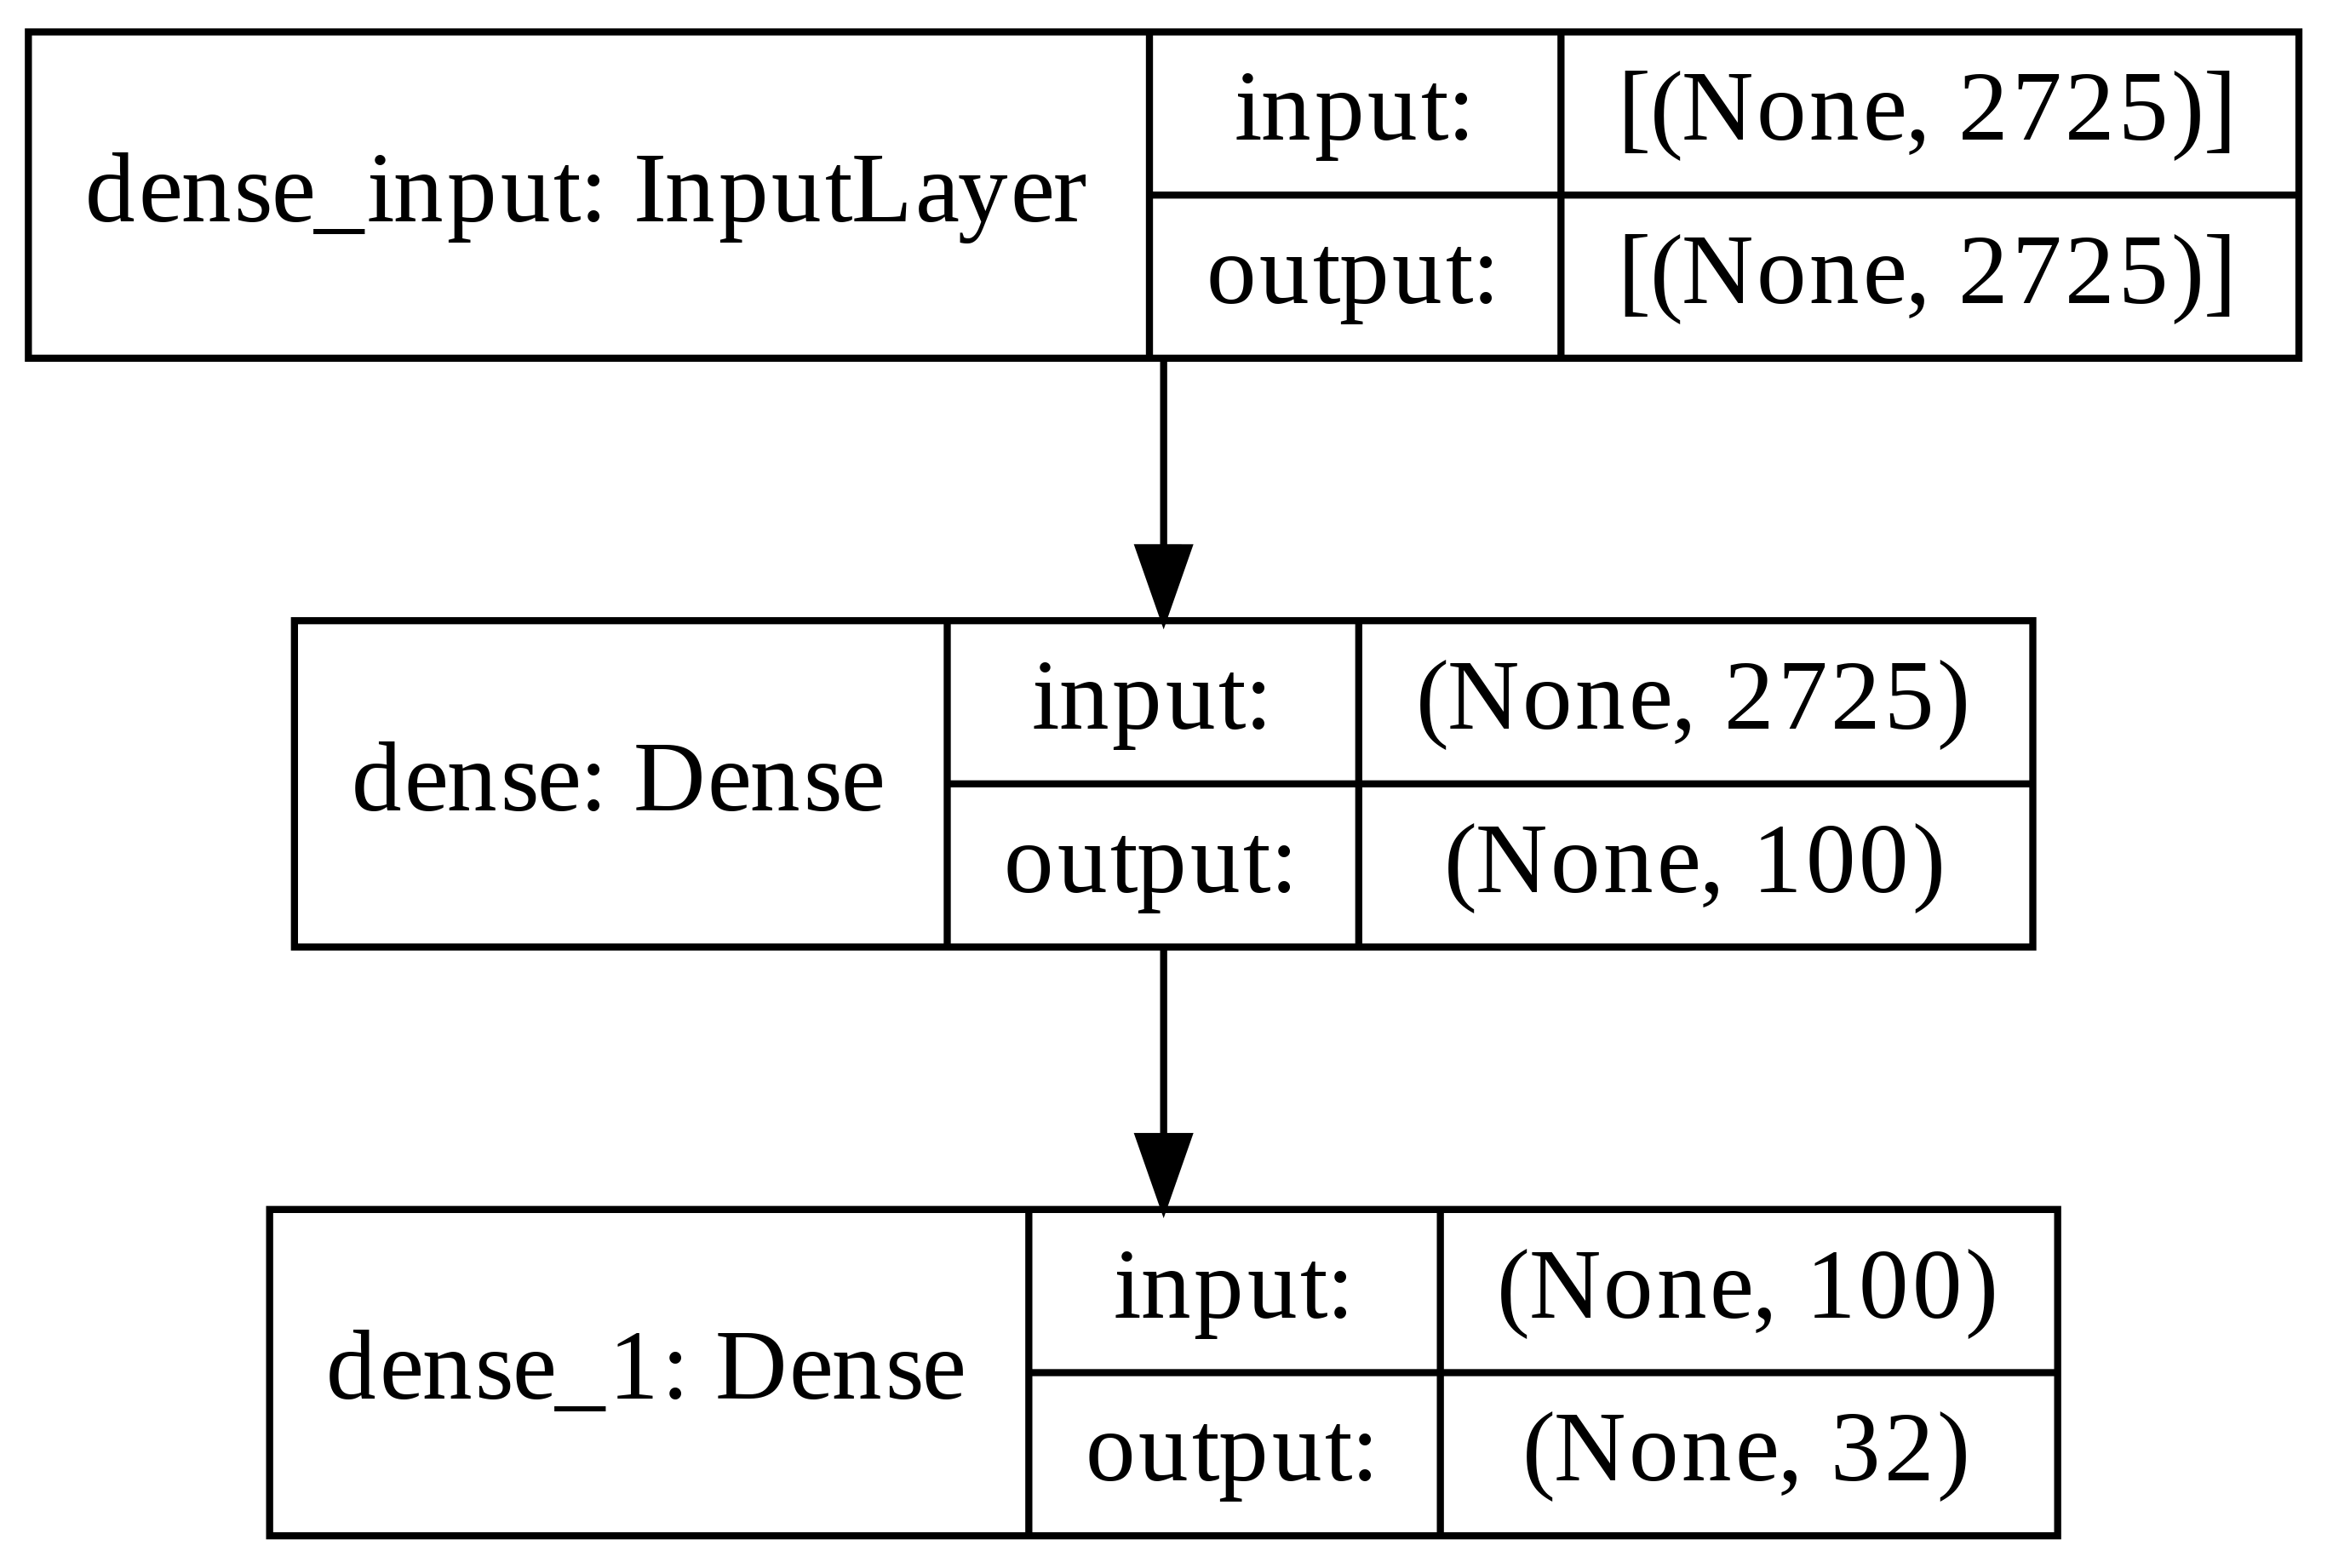

In [134]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=l1, l2=l2)))
model.add(Dense(units=uniq, activation=activation_func))
model.compile(loss=loss, optimizer=SGD(lr=lr, momentum=momentum), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)


In [135]:
with tf.device("GPU"):
    model.fit(X_tm_train, Y_tm_train, epochs=1000, batch_size=bs, verbose=1, validation_split=0.25, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/1000
2/2 [==============================] - 1s 274ms/step - loss: 10.4072 - accuracy: 0.0262 - auc: 0.5736 - val_loss: 9.6147 - val_accuracy: 0.2983 - val_auc: 0.6499
Epoch 2/1000
2/2 [==============================] - 0s 38ms/step - loss: 9.1944 - accuracy: 0.3330 - auc: 0.7328 - val_loss: 8.6100 - val_accuracy: 0.4202 - val_auc: 0.8369
Epoch 3/1000
2/2 [==============================] - 0s 35ms/step - loss: 8.1837 - accuracy: 0.5048 - auc: 0.9038 - val_loss: 7.8746 - val_accuracy: 0.5126 - val_auc: 0.9234
Epoch 4/1000
2/2 [==============================] - 0s 36ms/step - loss: 7.4824 - accuracy: 0.6304 - auc: 0.9592 - val_loss: 7.3911 - val_accuracy: 0.6723 - val_auc: 0.9477
Epoch 5/1000
2/2 [==============================] - 0s 41ms/step - loss: 7.0506 - accuracy: 0.7477 - auc: 0.9766 - val_loss: 7.0563 - val_accuracy: 0.7479 - val_auc: 0.9606
Epoch 6/1000
2/2 [==============================] - 0s 37ms/step - loss: 6.7714 - accuracy: 0.7914 - auc: 0.9823 - val_loss: 6.8259 -

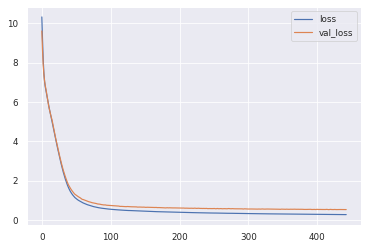

In [136]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [137]:
model.evaluate(X_tm_test, Y_tm_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.3917 - accuracy: 0.9400 - auc: 0.9995


[0.39171868562698364, 0.9399999976158142, 0.9995483756065369]

In [138]:
model.save(f"model_{label}.h5")
model = load_model(f"model_{label}.h5")
print(model.summary())
#plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               272600    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
Total params: 275,832
Trainable params: 275,832
Non-trainable params: 0
_________________________________________________________________
None


In [139]:
gc.collect()

2375

# evaluate on non used on topsbm training


In [140]:
df_generator = pd.read_csv('/content/drive/MyDrive/phd/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct', skiprows=2, sep='\t', chunksize=1000)

df_test_table = next(df_generator)
used_files = df_topics.index
classes = df_labels[label].unique()
test_samples = df_files[df_files[label].isin(classes) & ~df_files.index.isin(used_files)].index
train_genes = df.columns
df_test_table.set_index("Name", inplace=True)
df_test_table.index = [g[:15] for g in df_test_table.index]
df_test_table = df_test_table.reindex(index=train_genes, columns = test_samples).dropna(how="all", axis=0).dropna(how="all", axis=1)

for subdf in df_generator:
    subdf.set_index("Name", inplace=True)
    subdf.index = [g[:15] for g in subdf.index]
    subdf = subdf.reindex(index=train_genes, columns = test_samples).dropna(how="all", axis=0).dropna(how="all", axis=1)
    df_test_table = df_test_table.append(subdf)

df_test_table.head(3)

SAMPID,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2926-SM-5GZYI,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0226-SM-5GZXC,GTEX-111CU-0726-SM-5GZYD,GTEX-111CU-0826-SM-5EGIJ,GTEX-111CU-1026-SM-5EGIL,GTEX-111CU-1126-SM-5EGIM,GTEX-111CU-1826-SM-5GZYN,GTEX-111CU-2026-SM-5GZZC,GTEX-111FC-0126-SM-5N9DL,GTEX-111FC-0226-SM-5N9B8,GTEX-111FC-0326-SM-5GZZ1,GTEX-111FC-0426-SM-5N9CV,GTEX-111FC-0626-SM-5N9CU,GTEX-111FC-0826-SM-5GZWO,GTEX-111FC-1026-SM-5GZX1,GTEX-111FC-2526-SM-5GZXU,GTEX-111FC-3126-SM-5GZZ2,GTEX-111FC-3326-SM-5GZYV,GTEX-111VG-0008-SM-5Q5BG,GTEX-111VG-0326-SM-5GZX7,GTEX-111VG-0526-SM-5N9BW,GTEX-111VG-2226-SM-5N9DU,GTEX-111VG-2326-SM-5N9BK,GTEX-111VG-2426-SM-5GZXD,GTEX-111VG-2626-SM-5GZY2,GTEX-111YS-0006-SM-5NQBE,GTEX-111YS-0008-SM-5Q5BH,GTEX-111YS-0326-SM-5GZZ3,GTEX-111YS-0426-SM-5987O,GTEX-111YS-0526-SM-5GZXJ,GTEX-111YS-0726-SM-5GZY8,GTEX-111YS-0826-SM-5GZYK,GTEX-111YS-0926-SM-5EGGI,...,GTEX-ZYW4-1626-SM-5GIE6,GTEX-ZYW4-2226-SM-5GZYG,GTEX-ZYY3-0126-SM-5GZY5,GTEX-ZYY3-0226-SM-5E45M,GTEX-ZYY3-0526-SM-5E45G,GTEX-ZYY3-1226-SM-5EQKM,GTEX-ZYY3-1526-SM-5SIA9,GTEX-ZYY3-1626-SM-5EGJF,GTEX-ZYY3-1926-SM-5GZXS,GTEX-ZYY3-2926-SM-5GIEB,GTEX-ZYY3-3026-SM-5GIEJ,GTEX-ZYY3-3126-SM-5SI9L,GTEX-ZZ64-0126-SM-5GZXA,GTEX-ZZ64-0226-SM-5E44X,GTEX-ZZ64-0326-SM-5E45S,GTEX-ZZ64-0626-SM-5GZWR,GTEX-ZZ64-0726-SM-5GZX4,GTEX-ZZ64-0826-SM-5E449,GTEX-ZZ64-1026-SM-5GZXG,GTEX-ZZ64-1326-SM-5E444,GTEX-ZZ64-1526-SM-5E43K,GTEX-ZZ64-1626-SM-5E43W,GTEX-ZZ64-1726-SM-5GZYB,GTEX-ZZPT-0226-SM-5E43X,GTEX-ZZPT-0626-SM-5GZXT,GTEX-ZZPT-0926-SM-5GICZ,GTEX-ZZPT-1426-SM-5N9C5,GTEX-ZZPT-2926-SM-5EQ5S,GTEX-ZZPT-3026-SM-5GZXH,GTEX-ZZPU-0226-SM-5N9BV,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0826-SM-5GZX5,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1026-SM-5E457,GTEX-ZZPU-1126-SM-5N9CW,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2426-SM-5E44I,GTEX-ZZPU-2626-SM-5E45Y,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000268903,3.215,0.2492,1.3560,1.861,0.9263,2.387,4.814,4.190,5.825,11.580,3.914,4.292,9.94,5.288,0.4101,2.656,1.631,0.3239,0.9902,3.152,1.858,32.890,3.657,1.946,5.278,0.1672,1.063,7.144,0.8200,16.940,3.964,0.1721,181.100,0.000,1.230,0.2810,2.389,14.08,1.424,9.335,...,2.783,21.920,18.11,9.498,0.5459,6.498,37.510,17.18,21.460,9.559,5.565,5.532,0.5467,4.035,0.05527,2.933,1.028,0.1871,0.4623,0.06136,0.1730,1.583,2.677,3.709,1.729,1.705,28.450,1.217,3.090,17.540,11.430,11.50,1.361,11.61,3.334,34.48,4.806,3.350,0.7198,6.296
ENSG00000269981,7.012,0.4969,0.4806,1.855,1.7790,3.626,5.922,1.947,16.200,31.050,10.780,7.261,13.84,11.600,0.4845,4.066,3.061,0.7534,1.8220,5.431,1.900,33.260,5.363,2.822,2.769,0.0000,1.412,9.217,0.5129,31.910,5.113,0.5718,354.600,0.000,2.423,0.8405,2.847,20.47,4.773,30.120,...,2.999,34.420,35.24,17.810,0.7814,15.120,57.000,24.81,23.010,9.691,12.090,9.281,2.2610,8.645,1.02900,4.626,1.913,0.9946,0.7681,0.16310,0.3448,1.871,4.853,8.700,1.021,2.211,25.730,1.713,5.476,40.880,28.530,22.44,4.523,17.43,8.342,46.85,8.388,5.567,0.9568,12.590
ENSG00000225972,8.532,31.8700,13.2100,3.935,8.5650,34.880,9.042,19.980,8.569,7.501,20.430,30.180,21.55,10.330,14.7000,6.698,8.569,15.4500,2.0100,13.860,14.580,5.629,9.724,11.220,16.070,4.4110,16.680,7.676,9.1040,6.145,6.506,11.7000,4.542,3.887,14.150,27.0200,7.523,11.45,13.570,9.294,...,12.360,6.601,11.62,23.770,15.8500,5.095,4.957,13.49,6.739,6.741,17.730,22.670,7.0270,12.220,18.40000,16.250,10.430,18.6000,12.5500,8.71700,22.0300,25.590,10.130,20.040,12.220,16.120,3.777,13.660,18.120,5.832,7.532,10.78,20.890,78.93,85.340,13.29,16.060,13.960,24.4700,13.720


In [141]:
#project only HV genes
df_topic_test = df_test_table.reindex(index=df_words.index)
df_topic_test = df_topic_test.transpose().fillna(-1).astype(int)

df_topic_test = pd.DataFrame(data=np.matmul(df_topic_test.values,df_words.values), index=df_topic_test.index, columns=df_words.columns)
df_test=df_topic_test.divide(df_topic_test.mean(axis=0), axis=1) #normalize P(t|d)

df_test = df_test.subtract(df_topics.drop("tissue",1).mean(0),1).divide((X_train.max(0)-X_train.min(0)),1) #SGD transform

In [142]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values.astype(float)
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])
if uniq==1:
  Y_test = np.argmax(Y_test, axis=-1)
  uniq=1

os.system(f"mkdir -p data_{label}")
np.savetxt(f"data_{label}/classes.txt", classes, fmt="%s")
np.savetxt(f"data_{label}/X_test.txt", X_test)
np.savetxt(f"data_{label}/Y_test.txt", Y_test)

print(X_train.shape, X_test.shape)

(1000, 2725) (11460, 2725)


In [143]:
with tf.device("GPU"):
    model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)
    if uniq ==1:
        model_knn.evaluate(tf.convert_to_tensor(X_test), tf.convert_to_tensor(Y_test))
    else:
        model_knn.evaluate(tf.convert_to_tensor(X_test), tf.convert_to_tensor(Y_test))

359/359 - 1s - loss: 0.9778 - accuracy: 0.8222 - auc: 0.9762
Accuracy: 0.7716404886561955, AUC:0.8834222785607074


In [144]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [145]:
y_pred_p = model.predict(X_test)
if uniq>1:
  y_true = np.argmax(Y_test,axis=-1)
  y_pred = np.argmax(y_pred_p,axis=-1)
else:
  y_pred_p = y_pred_p.ravel()
  y_true = Y_test
  y_pred = np.ones(y_pred_p.shape)
  y_pred[y_pred_p<0.5]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


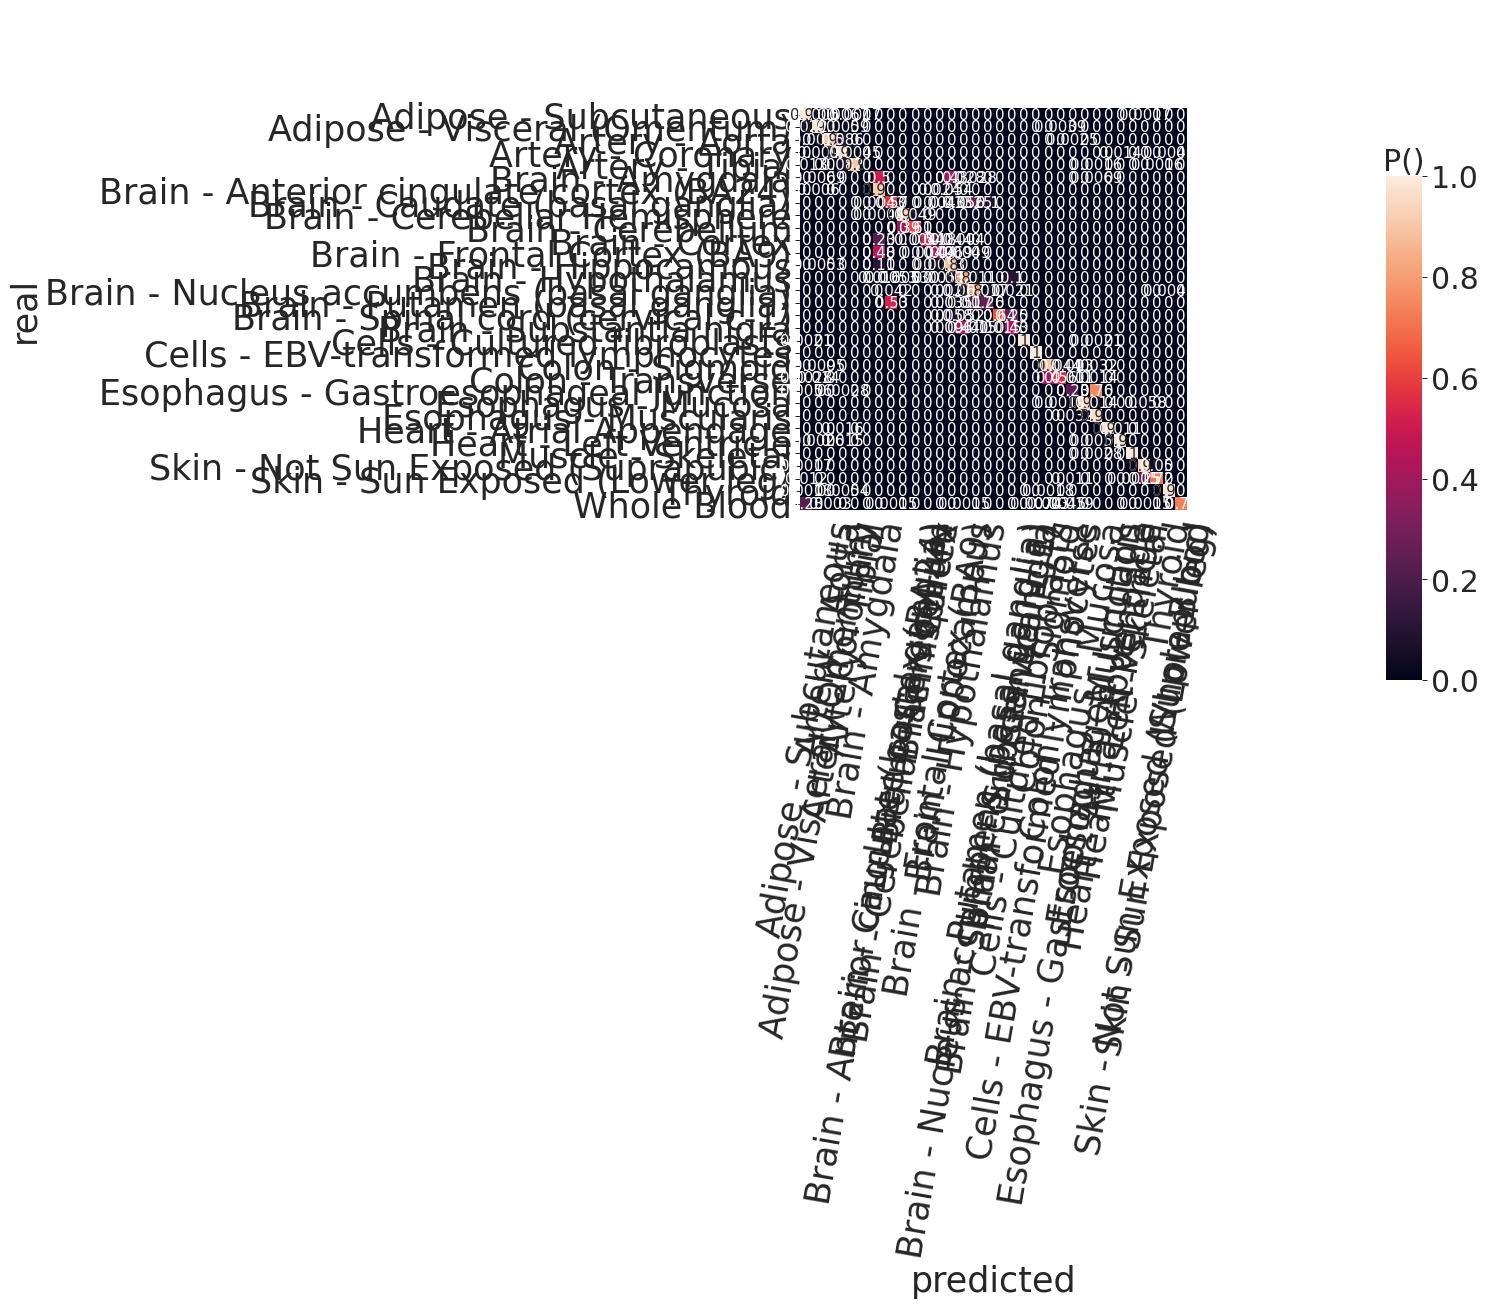

In [146]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=True,
                    annot_kws={"fontsize":15},
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=80)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()